# construct mock0

In [1]:
import os
import numpy as np 

In [2]:
from astropy import units as u
from astropy.cosmology import Planck13

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# "true" luminosity function
based on a power-law

In [4]:
def LF(Muv, z, phi): 
    alpha, beta, gamma, Muv_s = phi
    return (10**(gamma * (z - 9.)))/(10**(0.4*(alpha + 1)*(Muv - Muv_s) + 10**(0.4*(beta + 1)*(Muv - Muv_s))))

phi_amp = 6e-3
phi_true = np.array([-1.65, -1.5, -0.2, -19.5]) # fit by eye to zeus21 output

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2e-05, 0.1)

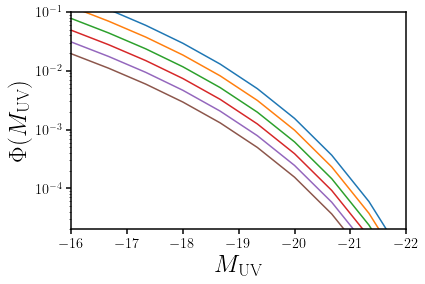

In [5]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)

Muv_bin = np.linspace(-16, -22, 10)
for z0 in [5., 6., 7., 8., 9., 10.]: 
    sub.plot(Muv_bin, phi_amp*LF(Muv_bin, z0, phi_true))

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(-16, -22)
sub.set_yscale('log')
sub.set_ylabel(r'$\Phi(M_{\rm UV})$', fontsize=25)
plt.ylim(2e-5, 1e-1)

In [6]:
import zeus21
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

In [7]:
CosmoParams_input = zeus21.Cosmo_Parameters_Input(zmin_CLASS=0.0) #make sure to provide zmin_CLASS lower than standard (5.0) if you want lower z results (eg HMFs)

CosmoParams, ClassyCosmo, CorrFclass ,HMFintclass =  zeus21.cosmo_wrapper(CosmoParams_input)

In [8]:
AstroParams_std = zeus21.Astro_Parameters(CosmoParams, accretion_model=0) #made accretion_model exponential, like in the paper (2306.09403)

In [9]:
#make mock
Nz=133
NMUV=300


zlist = np.linspace(4, 15, Nz)
zwidths = np.diff(zlist)
zwidths = np.append(zwidths,zwidths[-1])
dzuvlf = np.mean(zwidths) #just for UVLF calculation

MUVcenters = np.linspace(-15.,-24.,NMUV) #centers of bins
MUVwidths = -np.diff(MUVcenters)
MUVwidths = np.append(MUVwidths,MUVwidths[-1])

UVLFlist = np.array([phi_amp * LF(MUVcenters, z, phi_true) for z in zlist])


OmegaSurvey = 38.0*(1./60.)**2 * (np.pi/180)**2 #rad^2
#OmegaSurvey = 0.5 * (np.pi/180)**2 #rad^2
DeltaVlist = OmegaSurvey*CosmoParams.chiofzint(zlist)**2*dzuvlf/CosmoParams.Hofzint(zlist)

lambdalist = UVLFlist * np.outer(DeltaVlist, MUVwidths) #avg for Poisson

Nsample = np.random.poisson(lambdalist, ((Nz,NMUV)))

In [10]:
_UVFlist = np.array([zeus21.UVLFs.UVLF_binned(AstroParams_std,CosmoParams,HMFintclass,z,dzuvlf,MUVcenters,MUVwidths) for z in zlist])

/Users/chahah/projects/packages/zeus21/zeus21/UVLFs.py:27: RuntimeWarning: divide by zero encountered in log10
  MUVtab = 51.63 - 2.5 * np.log10(LUVtab) #AB magnitude


In [11]:
Ngal = 0
Ngaltot = np.sum(Nsample)

mock = []
for iz,zz in enumerate(zlist):
    for iMUV, MUV in enumerate(MUVcenters):
        for jgal in range(Nsample[iz,iMUV]):
            Ngal+=1
            mock = mock + [[zz, MUV]]

print(Ngal, Ngaltot)
mock = np.array(mock)

175301 175301


(-14.0, -22.0)

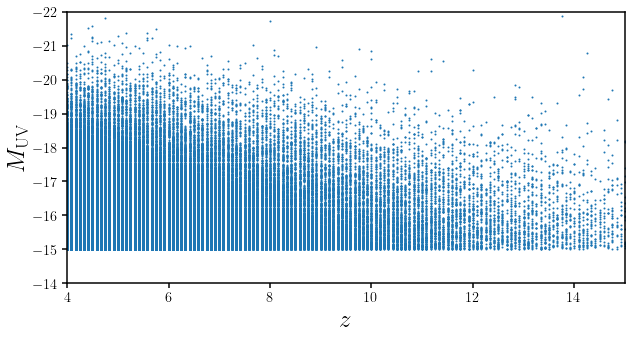

In [12]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## implement $z$ selection function
This is supposedly from simulations.

In [13]:
prob_z = np.exp(-(mock[:,0] - 9.0)**2)
select_z = prob_z > np.random.uniform(size=mock.shape[0])
print(np.mean(select_z))
print(np.sum(select_z))

0.06329113924050633
11095


(0.0, 1.1)

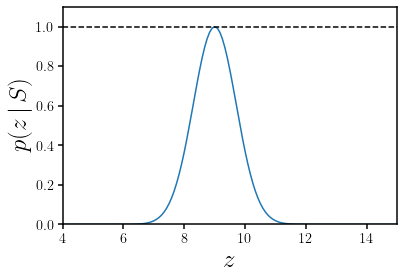

In [14]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
sub.plot(mock[:,0], prob_z)
sub.plot([0., 100], [1., 1.], c='k', ls='--')
sub.set_xlabel('$z$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylabel('$p(z\,|\,S)$', fontsize=25)
sub.set_ylim(0., 1.1)

(-14.0, -22.0)

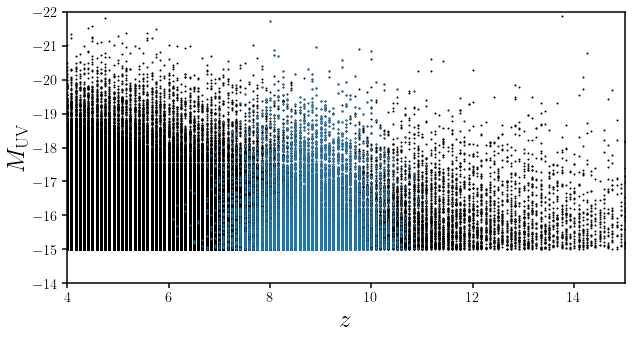

In [15]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1, c='k')
sub.scatter(mock[:,0][select_z], mock[:,1][select_z], s=1, c='C0')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

# implement $m_{\rm UV}$ cut 
on apparent magnitude. This should be more analogous to the actual selection in observations

In [16]:
from scipy.special import erf

In [17]:
def S_muv(muv, c_erf0=0.9, c_erf1 = 32):
    return 0.5*(1-erf(c_erf0*(muv - c_erf1)))

In [18]:
# convert mock absolute magnitude to apparent magnitudes
mock_muv = mock[:,1] + 5 * np.log10(Planck13.luminosity_distance(mock[:,0]).to(u.pc).value/10.)

In [21]:
# m_uv selection weights 
w_muv_select = S_muv(mock_muv, c_erf0=1., c_erf1=32)

In [24]:
select_muv = np.random.uniform(size=mock.shape[0]) < w_muv_select
print(np.mean(select_z & select_muv))
print(np.sum(select_z & select_muv))

0.0052652295195121535
923


# calculate $p(\theta\,|\,S)$

In [44]:
unif_Muv = np.random.uniform(-22, -15, size=int(1e7))
unif_z = np.random.uniform(4., 15, size=int(1e7))
unif_muv = unif_Muv + 5 * np.log10(Planck13.luminosity_distance(unif_z).to(u.pc).value/10.)

unif_select_z = np.exp(-(unif_z - 9.0)**2) > np.random.uniform(size=int(1e7))
unif_select_muv = np.random.uniform(size=len(unif_muv)) < S_muv(unif_muv, c_erf0=1., c_erf1=32)

(-15.0, -22.0)

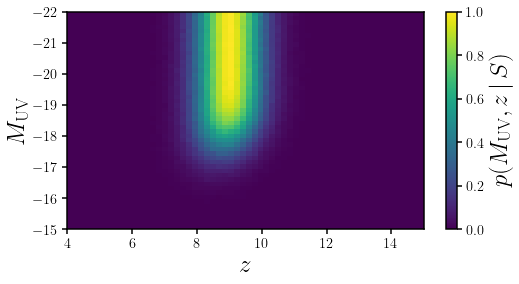

In [47]:
# h, bx, by = np.histogram2d(unif_z, unif_Muv, bins=[100, 100], range=[(4, 15), (-22, -15)])
# h_select, _, _ = np.histogram2d(unif_z[unif_select_z & unif_select_muv], unif_Muv[unif_select_z & unif_select_muv], 
#                                 bins=[100, 100], range=[(4, 15), (-22, -15)])


h, bx, by = np.histogram2d(unif_z, unif_Muv, bins=[60, 50], range=[(3.99, 15.01), (-22.01, -14.99)])
h_select, _, _ = np.histogram2d(unif_z[unif_select_z & unif_select_muv], unif_Muv[unif_select_z & unif_select_muv], bins=[60, 50], range=[(3.99, 15.01), (-22.01, -14.99)])

fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
X, Y = np.meshgrid(bx, by)
p = sub.pcolormesh(X, Y, (h_select/h).T, vmin=0., vmax=1)
plt.colorbar(p).set_label(r'$p(M_{\rm UV}, z\,|\,S)$', size=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_ylim(-15, -22)

In [48]:
np.save('/Users/chahah/data/binsin/mock0_selection.bx.npy', bx)
np.save('/Users/chahah/data/binsin/mock0_selection.by.npy', by)
np.save('/Users/chahah/data/binsin/mock0_selection.p_theta_S.npy', (h_select/h).T)

In [27]:
np.savetxt('/Users/chahah/data/binsin/mock0_selection.dat', 
          np.array([unif_z, unif_Muv, (unif_select_z & unif_select_muv).astype(int)]).T, header='z, Muv, select')

(-14.0, -22.0)

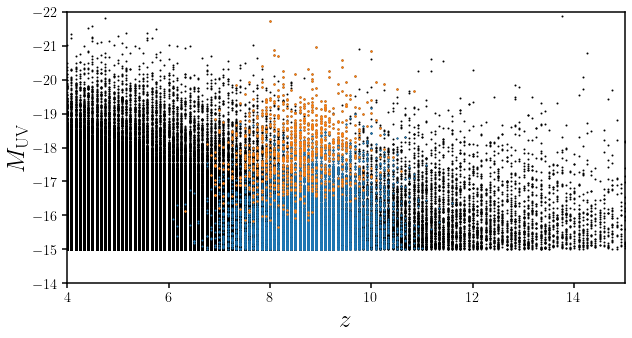

In [28]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1, c='k')
sub.scatter(mock[:,0][select_z], mock[:,1][select_z], s=1, c='C0')
sub.scatter(mock[:,0][select_z & select_muv], mock[:,1][select_z & select_muv], s=2, c='C1')

sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## add noise based on Finkelstein *et al.* (2023)
https://ui.adsabs.harvard.edu/abs/2023ApJ...946L..13F/abstract

In [29]:
ceers_z9 = np.loadtxt('/Users/chahah/data/binsin/ceers_S9_table.dat', skiprows=1)

(-14.0, -22.0)

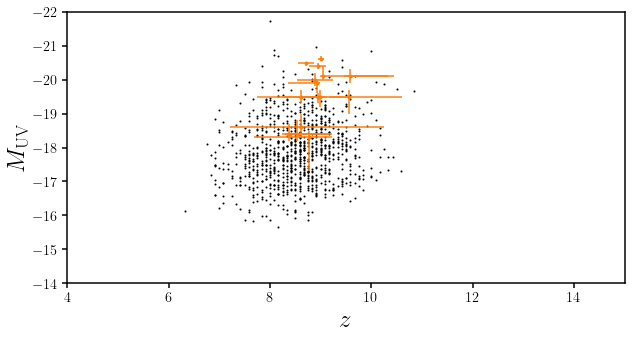

In [30]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0][select_z & select_muv], mock[:,1][select_z & select_muv], s=1, c='k')
sub.errorbar(ceers_z9[:,0], ceers_z9[:,3], 
             xerr=[ceers_z9[:,1], ceers_z9[:,2]], yerr=[ceers_z9[:,4], ceers_z9[:,5]], fmt='.C1')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

In [31]:
mock_Muv_1sig = 0.12 + 0.0*np.random.normal(size=mock.shape[0])

In [32]:
mock_Muv = mock[:,1] + mock_Muv_1sig * np.random.normal(size=mock.shape[0])

(-14.0, -22.0)

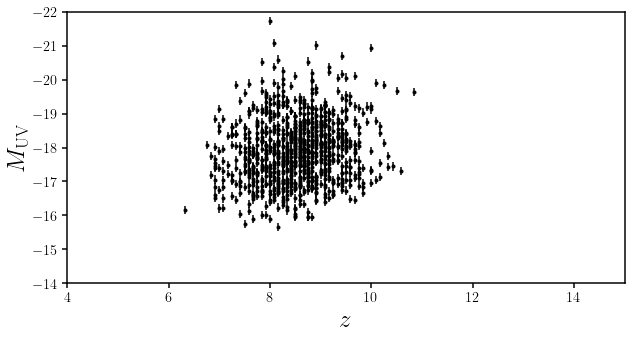

In [33]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.errorbar(mock[:,0][select_z & select_muv], mock_Muv[select_z & select_muv], 
             yerr=mock_Muv_1sig[select_z & select_muv], fmt='.k')

sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## lets add photo-$z$ noise

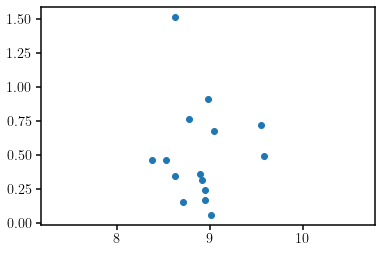

In [34]:
plt.scatter(ceers_z9[:,0], 0.5*(ceers_z9[:,1] + ceers_z9[:,2]))

error level of CEERS photo-zs

In [37]:
np.median(0.5*(ceers_z9[:,1] + ceers_z9[:,2])), np.std(0.5*(ceers_z9[:,1] + ceers_z9[:,2]))

(0.46499999999999997, 0.35837131581643084)

(array([3., 3., 4., 0., 3., 1., 0., 0., 0., 1.]),
 array([0.06  , 0.2055, 0.351 , 0.4965, 0.642 , 0.7875, 0.933 , 1.0785,
        1.224 , 1.3695, 1.515 ]),
 <BarContainer object of 10 artists>)

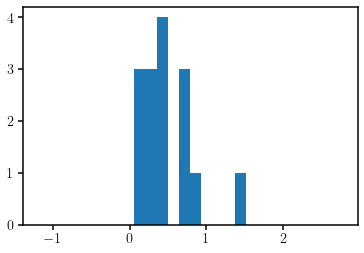

In [36]:
plt.hist(0.5*(ceers_z9[:,1] + ceers_z9[:,2]))

In [38]:
mock_photoz_1sig = (0.45 + 0.35 * np.random.normal(size=mock.shape[0])).clip(0.05, None) 

In [39]:
mock_photoz = mock[:,0] + mock_photoz_1sig * np.random.normal(size=mock.shape[0])

(-14.0, -22.0)

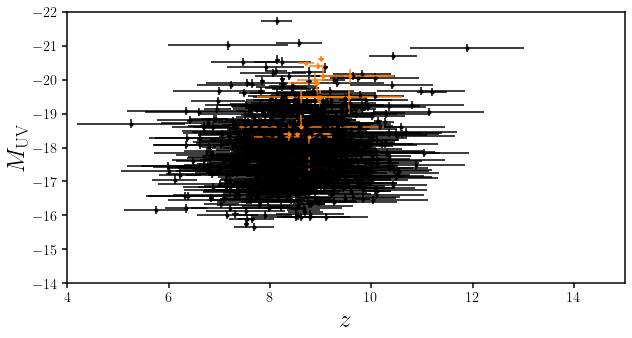

In [40]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.errorbar(mock_photoz[select_z & select_muv], mock_Muv[select_z & select_muv], 
             xerr=mock_photoz_1sig[select_z & select_muv], 
             yerr=mock_Muv_1sig[select_z & select_muv], fmt='.k')
sub.errorbar(ceers_z9[:,0], ceers_z9[:,3], 
             xerr=[ceers_z9[:,1], ceers_z9[:,2]], yerr=[ceers_z9[:,4], ceers_z9[:,5]], fmt='.C1')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## save mock0

In [43]:
np.savetxt('/Users/chahah/data/binsin/mock0.dat',
           np.array([mock[:,0][select_z & select_muv], 
                     mock[:,1][select_z & select_muv], 
                     mock_photoz[select_z & select_muv], 
                     mock_Muv[select_z & select_muv], 
                     mock_photoz_1sig[select_z & select_muv], 
                     mock_Muv_1sig[select_z & select_muv], 
                     prob_z[select_z & select_muv], 
                     w_muv_select[select_z & select_muv]]).T, 
           header='z_true, Muv_true, z, Muv, sig_z, sig_Muv, w_z, w_muv')